In [1]:
#!pip install transformers datasets seaborn scikit-learn --quiet

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, get_scheduler
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from wordcloud import WordCloud
import time
import warnings
warnings.filterwarnings("ignore")




c:\Users\faris\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device: {device}")

df = pd.read_csv("IMDB Dataset.csv")

Using device: cuda


                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
Class Distribution:
 sentiment
positive    25000
negative    25000
Name: count, dtype: int64


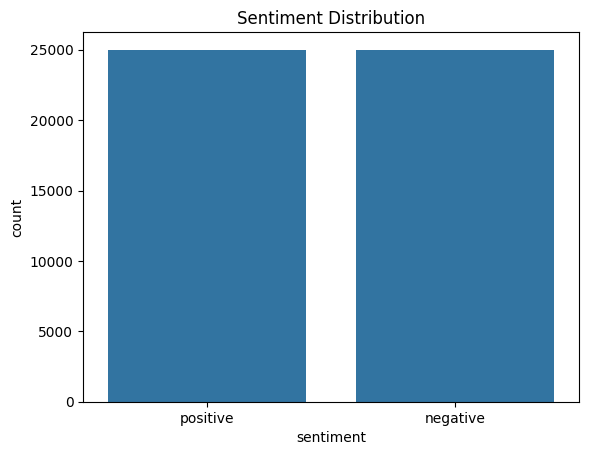

In [5]:
print(df.head())
print("Class Distribution:\n", df['sentiment'].value_counts())

# Convert sentiment to binary labels
df['label'] = df['sentiment'].map({'positive': 1, 'negative': 0})

# Plot sentiment distribution
sns.countplot(data=df, x='sentiment')
plt.title("Sentiment Distribution")
plt.show()


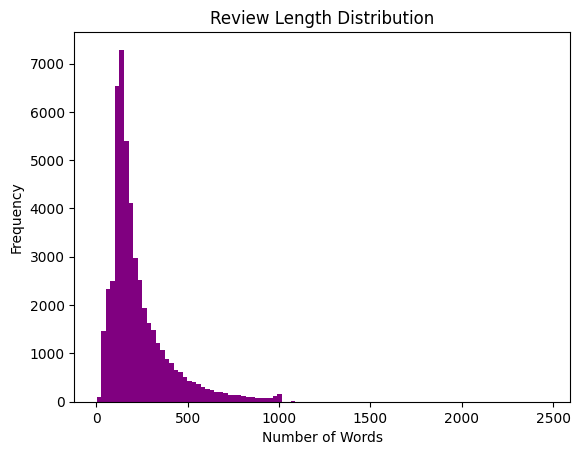

In [6]:
# Review Lengths
review_lengths = df['review'].apply(lambda x: len(x.split()))
plt.hist(review_lengths, bins=100, color='purple')
plt.title("Review Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

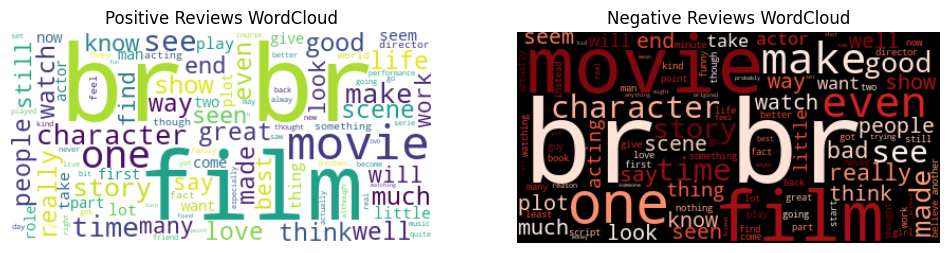

In [7]:
# Word Clouds
positive_reviews = " ".join(df[df['label'] == 1]['review'])
negative_reviews = " ".join(df[df['label'] == 0]['review'])

wc_pos = WordCloud(max_words=100, background_color='white').generate(positive_reviews)
wc_neg = WordCloud(max_words=100, background_color='black', colormap='Reds').generate(negative_reviews)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(wc_pos, interpolation='bilinear')
plt.axis('off')
plt.title("Positive Reviews WordCloud")

plt.subplot(1, 2, 2)
plt.imshow(wc_neg, interpolation='bilinear')
plt.axis('off')
plt.title("Negative Reviews WordCloud")
plt.show()


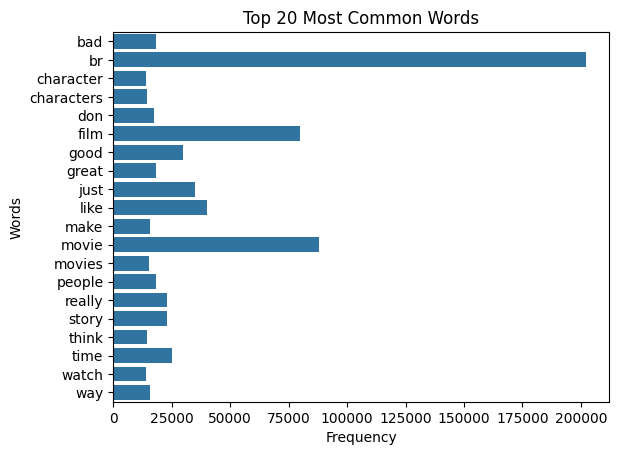

In [8]:
# Top 20 Common Words
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer(stop_words='english', max_features=20)
X = vec.fit_transform(df['review'])

word_freq = np.asarray(X.sum(axis=0)).flatten()
word_labels = vec.get_feature_names_out()

sns.barplot(x=word_freq, y=word_labels)
plt.title("Top 20 Most Common Words")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.show()

In [9]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['review'].values, df['label'].values, test_size=0.2, stratify=df['label'], random_state=42)


In [10]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class IMDBDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            max_length=self.max_len,
            padding='max_length',
            return_tensors='pt')
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_dataset = IMDBDataset(train_texts, train_labels, tokenizer)
val_dataset = IMDBDataset(val_texts, val_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)


In [11]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [12]:
optimizer = AdamW(model.parameters(), lr=2e-5)
epochs = 4
total_steps = len(train_loader) * epochs
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=total_steps)


In [13]:
def train():
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        scheduler.step()
    return total_loss / len(train_loader)


In [14]:
def evaluate():
    model.eval()
    total_loss = 0
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            total_loss += outputs.loss.item()
            logits = outputs.logits
            predictions.extend(torch.argmax(logits, axis=1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    return total_loss / len(val_loader), predictions, true_labels



Epoch 1/4
Train Loss: 0.2466 | Val Loss: 0.2002 | Time: 1018.29s
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      5000
           1       0.94      0.90      0.92      5000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



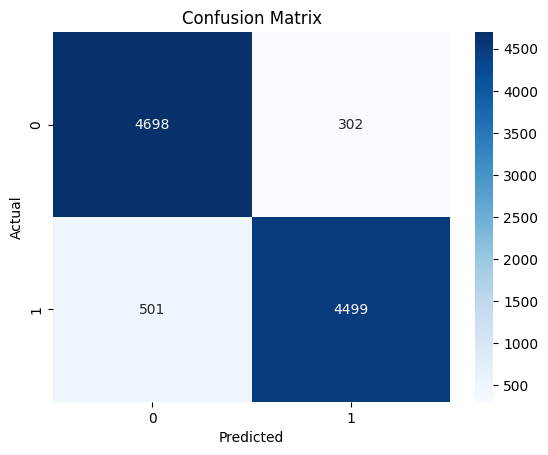


Epoch 2/4
Train Loss: 0.1218 | Val Loss: 0.2011 | Time: 1018.05s
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      5000
           1       0.95      0.90      0.92      5000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



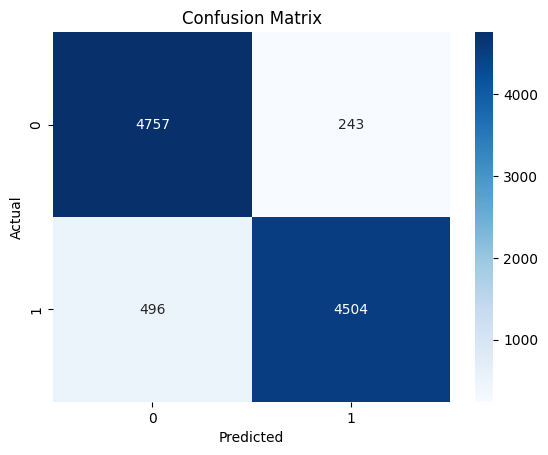


Epoch 3/4
Train Loss: 0.0472 | Val Loss: 0.2330 | Time: 1007.68s
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      5000
           1       0.92      0.94      0.93      5000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



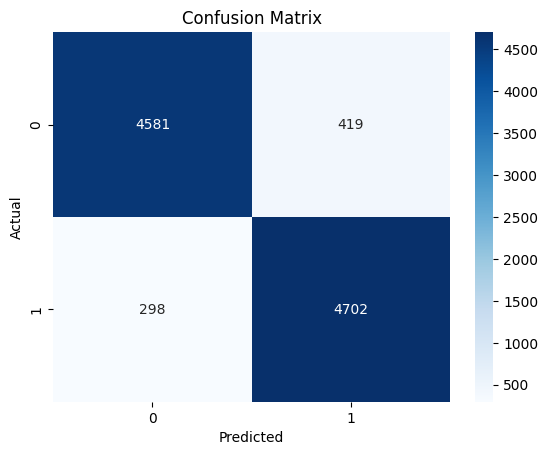


Epoch 4/4
Train Loss: 0.0173 | Val Loss: 0.2947 | Time: 1004.60s
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      5000
           1       0.93      0.93      0.93      5000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



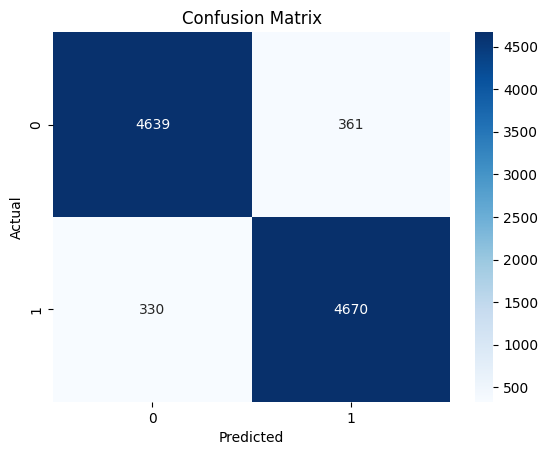

In [15]:
train_losses, val_losses = [], []
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    start_time = time.time()

    train_loss = train()
    val_loss, preds, trues = evaluate()
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Time: {time.time() - start_time:.2f}s")
    print(classification_report(trues, preds))

    cm = confusion_matrix(trues, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


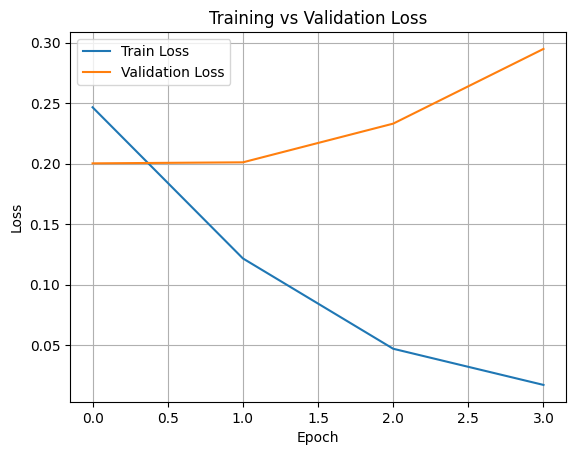

('bert_sentiment_model\\tokenizer_config.json',
 'bert_sentiment_model\\special_tokens_map.json',
 'bert_sentiment_model\\vocab.txt',
 'bert_sentiment_model\\added_tokens.json')

In [17]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()
model.save_pretrained("bert_sentiment_model")
tokenizer.save_pretrained("bert_sentiment_model")
